# Transfer learning

We are going to download a pre-trained model and fine-tune it to a dataset of our choosing.

First, setup

In [10]:
#!/usr/bin/env python3
 
##########################################################
# Copyright (c) Jesper Vang <jesper_vang@me.com>         #
# Created on 26 Jul 2021                                 #
# Version:	0.0.1                                        #
# What: ? 						                         #
##########################################################

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn import datasets
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from pprint import pprint # use pprint() to pretty print


print("Pandas Version: {}".format(pd.__version__))
print("Numpy Version: {}".format(np.__version__))
print("Matplotlib Version: {}".format(matplotlib.__version__))
print("Scikit-learn Version: {}".format(sklearn.__version__))
print("Seaborn Version: {}".format(sns.__version__))
print("Tensorflow Version: {}".format(tf.__version__))

np.set_printoptions(suppress=True, linewidth=130)


%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 8)

# Where to save the figures
print(f'the current path is: {os.getcwd()}')
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Pandas Version: 1.3.0
Numpy Version: 1.19.5
Matplotlib Version: 3.4.2
Scikit-learn Version: 0.24.2
Seaborn Version: 0.11.1
Tensorflow Version: 2.5.0
the current path is: /Users/jvang/Documents/Projects/Applied_AI_IT_Uni/day07


The NN layers can be frozen to prevent them from changing during learning.

When a trainable weight becomes non-trainable, its value is no longer updated during training.



In [2]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = True  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


If you set `trainable = False` on a model or on any layer that has sublayers, all children layers become non-trainable as well.

In [3]:
inner_model = keras.Sequential(
  [
   keras.layers.InputLayer((3,)),
   keras.layers.Dense(3, activation="relu"),
   keras.layers.Dense(3, activation="relu"),
  ]
)

model = keras.Sequential(
  [keras.layers.InputLayer((3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursive

# Getting the training data
For this example, we will use the `cats vs dogs` dataset.

In [4]:
train_ds, validation_ds, test_ds = tfds.load(
  "cats_vs_dogs",
  # Reserve 10% for validation and 10% for test
  split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
  as_supervised=True,  # Include labels
)

print(f"# training samples: {tf.data.experimental.cardinality(train_ds)}")
print(f"# validation samples: {tf.data.experimental.cardinality(validation_ds)}")
print(f"# test samples: {tf.data.experimental.cardinality(test_ds)}")

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteDCESLL/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
# training samples: 9305
# validation samples: 2326
# test samples: 2326


Visualise the data

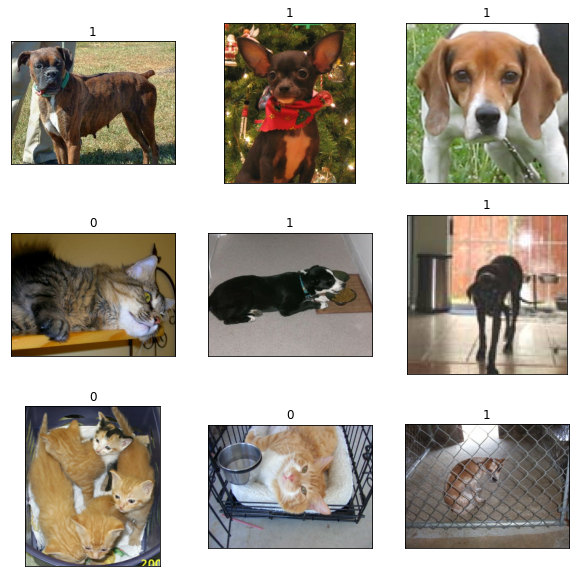

In [5]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])

Let's batch data like we did with the MNIST example

In [6]:
# Resize data
size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

# Batch data
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

# Data augmentation
In order to improve the generallity of learning, or if the training data is too small or has uniformity in transformations, we often "augment" the training data. Augmentation will include making extra graining examples by taking the existing ones and deforming them or adding some kind of transformation.

Data augmentation increases the size of the training/validation set and introduces variablility.

In this example, we will make a augmentation function that will randomly flip the image and rotate it a bit.

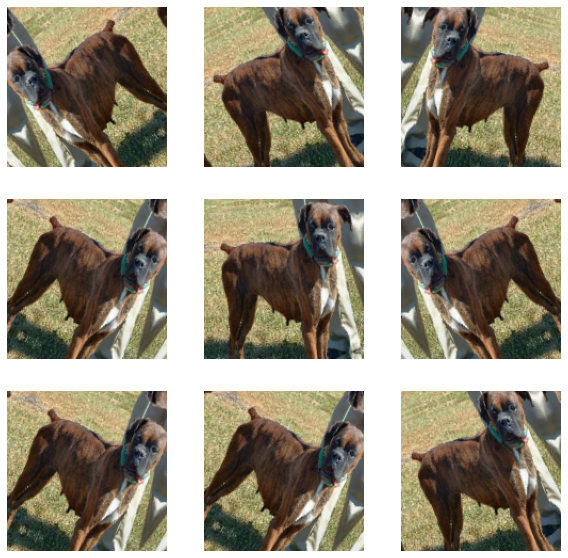

In [9]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
  ])

import numpy as np

for images, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(
      tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.axis("off")

## Example transfer learning workflow

1.   Instantiate a base model and load pre-trained weights into it;
2.   Freeze all layers in the base model by setting `trainable = False`;
3.   Create a new model on top of the output of one (or several) layers from the base model.
4.   Train your new model on your new dataset.

The following code is using the "Functional API" to chaing the layers in order to create the model.

This has the same effect as creating a NN model with subclassing:

E.g.
```python
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

model = MyModel()
```

In [11]:
base_model = keras.applications.Xception(
  weights="imagenet",  # Load weights pre-trained on ImageNet.
  input_shape=(150, 150, 3),
  include_top=False, # Do not include the ImageNet classifier at the top.
)  

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
# Apply random data augmentation
# In this case, we will just disturb the already existing data
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.)
# The normalization layer does the following:
#            outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model is not supposed to train, so we will put it into inference mode
#    `training=False`
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049  

Now is the time to train the last CNN layers

In [12]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 58s 89ms/step - loss: 0.1664 - binary_accuracy: 0.9274 - val_loss: 0.0825 - val_binary_accuracy: 0.9699
Epoch 2/20
291/291 [==============================] - 23s 77ms/step - loss: 0.1188 - binary_accuracy: 0.9494 - val_loss: 0.0763 - val_binary_accuracy: 0.9690
Epoch 3/20
291/291 [==============================] - 23s 79ms/step - loss: 0.1072 - binary_accuracy: 0.9566 - val_loss: 0.0739 - val_binary_accuracy: 0.9699
Epoch 4/20
291/291 [==============================] - 22s 77ms/step - loss: 0.1060 - binary_accuracy: 0.9562 - val_loss: 0.0728 - val_binary_accuracy: 0.9699
Epoch 5/20
291/291 [==============================] - 23s 78ms/step - loss: 0.1050 - binary_accuracy: 0.9577 - val_loss: 0.0758 - val_binary_accuracy: 0.9678
Epoch 6/20
291/291 [==============================] - 23s 78ms/step - loss: 0.0998 - binary_accuracy: 0.9593 - val_loss: 0.0699 - val_binary_accuracy: 0.9729
Epoch 7/20
291/291 [==============================] 

Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.

**Important note:**
Although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [13]:
base_model.trainable = True
model.summary()

model.compile(
  optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
  loss=keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2049  